In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
%matplotlib inline

## MNIST

In [2]:
dl_train = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/mnist', train=True, download=False))

dl_test  = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/mnist', train=False, download=False))

In [3]:
train_data   = dl_train.dataset.data.to(dtype=torch.float32)
train_labels = dl_train.dataset.targets

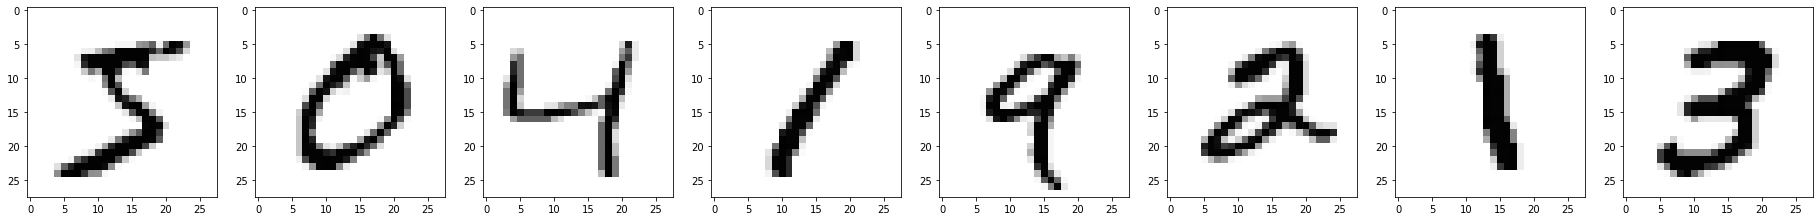

In [4]:
fig_mnist, ax = plt.subplots(1,8, figsize=(8*4,4))
for i in range(8):
    ax[i].imshow(train_data[i].numpy(), cmap='Greys');

In [5]:
train_labels[0:8]

tensor([5, 0, 4, 1, 9, 2, 1, 3])

In [6]:
train_dataset = torch.utils.data.TensorDataset( 
    (train_data/256.0).view(-1,28*28), 
    train_labels)

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=100, 
                                           shuffle=True)

In [8]:
test_data   = dl_test.dataset.data.to(dtype=torch.float32)
test_labels = dl_test.dataset.targets
test_dataset = torch.utils.data.TensorDataset(
    (test_data/256.0).view(-1,28*28), test_labels)

In [9]:
model = torch.nn.Sequential(
    nn.Linear(28*28,512), nn.ReLU(),
    nn.Linear(512,256),   nn.ReLU(),
    nn.Linear(256,128),   nn.ReLU(),
    nn.Linear(128,64),    nn.ReLU(),
    nn.Linear(64,10)
)


## Weight initialisation

In [10]:
def init_layer_uniform(sigma):
    def init(layer): 
        if isinstance(layer,torch.nn.modules.linear.Linear):
            torch.nn.init.uniform_(layer.weight,-sigma,sigma)
            if layer.bias is not None:
                torch.nn.init.zeros_(layer.bias)
    return init  

In [11]:
model.apply(init_layer_uniform(0.01))

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=10, bias=True)
)

In [12]:
torch.var(train_dataset[:][0])

tensor(0.0942)

In [13]:
mnist_out = model(train_dataset[:][0])
torch.var(mnist_out)

tensor(1.8650e-13, grad_fn=<VarBackward0>)

In [14]:
optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.6)

In [15]:
loss_f = nn.CrossEntropyLoss()

In [16]:
errors = []
batches = 0
epochs = 0

In [17]:
%%time
for e in range(10):
    for d in train_loader:        
        optim.zero_grad()
        features, labels = d
        pred = model(features)
        loss = loss_f(pred, labels)
        errors.append(loss.item())
        loss.backward()
        optim.step()
        batches += 1
    epochs += 1   
print(loss)        

tensor(2.3011, grad_fn=<NllLossBackward>)
CPU times: user 2min 28s, sys: 1min 14s, total: 3min 43s
Wall time: 2min 44s


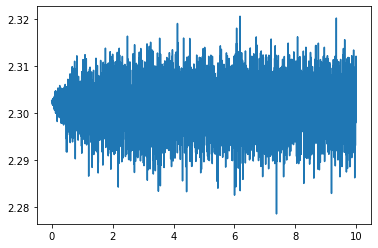

In [18]:
plt.plot(np.linspace(0,epochs, batches),errors);

In [19]:
with torch.no_grad():
    pred = torch.softmax(model(train_dataset[:][0]),1)
    ac = torch.sum(torch.argmax(pred,1)==train_labels).to(dtype=torch.float32)/len(train_dataset)
ac  

tensor(0.1124)

In [20]:
with torch.no_grad():
    pred = torch.softmax(model(test_dataset[:][0]),1)
    ac = torch.sum(torch.argmax(pred,1)==test_labels).to(dtype=torch.float32)/len(test_dataset)
ac    

tensor(0.1135)

In [21]:
torch.var(train_dataset[:][0])

tensor(0.0942)

In [22]:
mnist_out = model(train_dataset[:][0])
torch.var(mnist_out)

tensor(0.0028, grad_fn=<VarBackward0>)

$$x^{l+1}_i = f(y^{l}_i), 
\qquad y^{l}_i =\sum_{j=1}^{n_l} w^{l}_{ij}x^{l}_j$$

$$w^l_{ij} \sim \text{i.i.d}\qquad E[w]=0$$

$$E[y^{l}_i] = \sum_{j=1}^{n_l} E[w^{l}_{ij}x^{l}_j] = 
\sum_{j=1}^{n_l} E[w^{l}_{ij}]E[x^{l}_j]=0$$

$$Var[y^{l}_i ]= E[(y^{l}_i-E[y^{l}_i ])^2] = E[(y^{l}_i)^2]$$ 

$$Var[y^{l}_i] = 
E\left[\left(
\sum_{j=1}^{n_l} w^{l}_{ij}x^{l}_j
\right)^2\right]
$$

$$Var[y^{l}_i] = 
E\left[\left(
\sum_{j=1}^{n_l} w^{l}_{ij}x^{l}_j
\right)
\left(
\sum_{k=1}^{n_l} w^{l}_{ik}x^{l}_k
\right)
\right]
$$

$$Var[y^{l}_i] = 
E\left[
\sum_{j,k=1}^{n_l} w^{l}_{ij}x^{l}_j
 w^{l}_{ik}x^{l}_k
\right]= 
\sum_{j,k=1}^{n_l} E\left[
 w^{l}_{ij}x^{l}_j
 w^{l}_{ik}x^{l}_k
\right]
$$

$$Var[y^{l}_i] = 
\sum_{j,k=1}^{n_l} 
E\left[w^{l}_{ij} w^{l}_{ik}\right]
E\left[
x^{l}_k x^{l}_j
\right]
$$

$$E\left[w^{l}_{ij} w^{l}_{ik}\right]=\delta_{jk}E[(w^l_{ij})^2]= \delta_{jk} Var [w^l]$$

$$Var[y^{l}_i] = 
\sum_{j,k=1}^{n_l} 
\delta_{jk}Var [w^l]
E\left[
x^{l}_k x^{l}_j
\right] = 
\sum_{j}^{n_l} 
Var [w^l]
E\left[
(x^{l}_j)^2
\right] = 
n_l Var [w^{l}]E[(x^l)^2]
$$

$$\newcommand{\relu}{\operatorname{relu}}$$
$$x^l = \relu(y^{l-1})=\max(0,y^{l-1}),\qquad P(y^{l-1})=P(-y^{l-1})$$

$$E[(x^l)^2]=\int\limits_0^\infty\!\!\text{d}y^{l-1} \,\max(0,y^{l-1})=\int\limits_0^\infty\!\!\text{d}y^{l-1}P (y^{l-1})\,(y^l)^2=
\frac{1}{2}\int\limits_{-\infty}^\infty\!\!\text{d}y^{l-1} P(y)\,(y^{l-1})^2=\frac{1}{2}Var[y^{l-1}]$$

$$Var[y^{l}_i] = 
n_l Var[w^{l}]E[(x^l)^2]=\frac{1}{2}n_l Var[w^l]Var[y^{l-1}]
$$

$$Var[y^L]=Var[y^1]\left(\prod_2^L\frac{1}{2} n_l Var[w^{l}]\right)$$

$$\left(\prod_2^L\frac{1}{2} n_l Var[w^{l}]\right) = 1$$

$$Var[w^{l}] = \frac{2}{n_l}$$

$$std(w_l)=\sqrt{\frac{2}{n_l}}$$

### Uniform distribution

$$w\in (-\sigma, \sigma),\quad P(w)=\frac{1}{2\sigma}$$

$$Var(w)=\frac{1}{2\sigma}\int\limits_{-\sigma}^\sigma w^2 
=\frac{1}{2\sigma}\frac{1}{3} 2 \sigma^3 =\frac{1}{3}\sigma^2
$$

$$\sigma = \sqrt{3}\;  std(w)=\sqrt{\frac{6}{n_l}}$$

In [23]:
def init_layer_norm_gauss():
    def init(layer): 
        if isinstance(layer,torch.nn.modules.linear.Linear):
            fan_in = layer.weight.size(1)
            sigma  = np.sqrt(2/fan_in)    
            torch.nn.init.normal_(layer.weight,0,sigma)
            if layer.bias is not None:
                torch.nn.init.zeros_(layer.bias)
    return init  

In [24]:
model.apply(init_layer_norm_gauss())

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=10, bias=True)
)

In [25]:
torch.var(train_dataset[:][0]*train_dataset[:][0])

tensor(0.0824)

In [26]:
mnist_out = model(train_dataset[:][0])
torch.var(mnist_out)

tensor(0.1533, grad_fn=<VarBackward0>)

In [27]:
def init_layer_norm_uniform():
    def init(layer): 
        if isinstance(layer,torch.nn.modules.linear.Linear):
            fan_in = layer.weight.size(1)
            sigma  = np.sqrt(6/fan_in)    
            torch.nn.init.uniform_(layer.weight,-sigma,sigma)
            if layer.bias is not None:
                torch.nn.init.zeros_(layer.bias)
    return init  

In [28]:
model.apply(init_layer_norm_gauss())

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=10, bias=True)
)

In [29]:
torch.var(train_dataset[:][0]*train_dataset[:][0])

tensor(0.0824)

In [30]:
mnist_out = model(train_dataset[:][0])
torch.var(mnist_out)

tensor(0.2193, grad_fn=<VarBackward0>)